In [4]:
import dicom, lmdb, cv2, re, sys
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero

In [3]:
SAX_SERIES = {
    # challenge training
    "SC-HF-I-1": "0004",
    "SC-HF-I-2": "0106",
    "SC-HF-I-4": "0116",
    "SC-HF-I-40": "0134",
    "SC-HF-NI-3": "0379",
    "SC-HF-NI-4": "0501",
    "SC-HF-NI-34": "0446",
    "SC-HF-NI-36": "0474",
    "SC-HYP-1": "0550",
    "SC-HYP-3": "0650",
    "SC-HYP-38": "0734",
    "SC-HYP-40": "0755",
    "SC-N-2": "0898",
    "SC-N-3": "0915",
    "SC-N-40": "0944",
}

def shrink_case(case):
    toks = case.split("-")
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        match = re.search(r"/([^/]*)/contours-manual/IRCCI-expert/IM-0001-(\d{4})-icontour-manual.txt", ctr_path)
        self.case = shrink_case(match.group(1))
        self.img_no = int(match.group(2))
    
    def __str__(self):
        return "<Contour for case %s, image %d>" % (self.case, self.img_no)
    
    __repr__ = __str__

def load_contour(contour, img_path):
    filename = "IM-%s-%04d.dcm" % (SAX_SERIES[contour.case], contour.img_no)
    full_path = os.path.join(img_path, contour.case, filename)
    f = dicom.read_file(full_path)
    img = f.pixel_array.astype(np.int)
    ctrs = np.loadtxt(contour.ctr_path, delimiter=" ").astype(np.int)
    label = np.zeros_like(img, dtype="uint8")
    cv2.fillPoly(label, [ctrs], 1)
    return img, label
    
def get_all_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-0001-*-icontour-manual.txt')]
    print("Shuffle data")
    np.random.shuffle(contours)
    print("Number of examples: {:d}".format(len(contours)))
    extracted = map(Contour, contours)
    return extracted

def export_all_contours(contours, img_path, lmdb_img_name, lmdb_label_name):
    for lmdb_name in [lmdb_img_name, lmdb_label_name]:
        db_path = os.path.abspath(lmdb_name)
        if os.path.exists(db_path):
            shutil.rmtree(db_path)
    counter_img = 0
    counter_label = 0
    batchsz = 100
    print("Processing {:d} images and labels...".format(len(contours)))
    for i in xrange(int(np.ceil(len(contours) / float(batchsz)))):
        batch = contours[(batchsz*i):(batchsz*(i+1))]
        if len(batch) == 0:
            break
        imgs, labels = [], []
        for idx,ctr in enumerate(batch):
            try:
                img, label = load_contour(ctr, img_path)
                imgs.append(img)
                labels.append(label)
                if idx % 20 == 0:
                    print ctr
                    plt.imshow(img)
                    plt.show()
                    plt.imshow(label)
                    plt.show()
            except IOError:
                continue
        db_imgs = lmdb.open(lmdb_img_name, map_size=1e12)
        with db_imgs.begin(write=True) as txn_img:
            for img in imgs:
                datum = caffe.io.array_to_datum(np.expand_dims(img, axis=0))
                txn_img.put("{:0>10d}".format(counter_img), datum.SerializeToString())
                counter_img += 1
        print("Processed {:d} images".format(counter_img))
        db_labels = lmdb.open(lmdb_label_name, map_size=1e12)
        with db_labels.begin(write=True) as txn_label:
            for lbl in labels:
                datum = caffe.io.array_to_datum(np.expand_dims(lbl, axis=0))
                txn_label.put("{:0>10d}".format(counter_label), datum.SerializeToString())
                counter_label += 1
        print("Processed {:d} labels".format(counter_label))
    db_imgs.close()
    db_labels.close()

In [6]:
SUNNYBROOK_ROOT_PATH = "./"

TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "TrainingDataContours")
TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "challenge_training")

print TRAIN_CONTOUR_PATH
print TRAIN_IMG_PATH

./TrainingDataContours
./challenge_training


In [7]:
#To check the path is correct
print os.listdir(TRAIN_CONTOUR_PATH)
print os.listdir(TRAIN_IMG_PATH)

['.DS_Store', 'SC-HF-I-01', 'SC-HF-I-02', 'SC-HF-I-04', 'SC-HF-I-40', 'SC-HF-NI-03', 'SC-HF-NI-04', 'SC-HF-NI-34', 'SC-HF-NI-36', 'SC-HYP-01', 'SC-HYP-03', 'SC-HYP-38', 'SC-HYP-40', 'SC-N-02', 'SC-N-03', 'SC-N-40']
['.DS_Store', 'License_and_README.pdf', 'SC-HF-I-1', 'SC-HF-I-2', 'SC-HF-I-4', 'SC-HF-I-40', 'SC-HF-NI-3', 'SC-HF-NI-34', 'SC-HF-NI-36', 'SC-HF-NI-4', 'SC-HYP-1', 'SC-HYP-3', 'SC-HYP-38', 'SC-HYP-40', 'SC-N-2', 'SC-N-3', 'SC-N-40']


In [11]:
#case refers to the case string
#img_numbers are the last four digits in the contour file name
extracted = get_all_contours(TRAIN_CONTOUR_PATH)
print extracted[1]
print type(extracted[0])

Shuffle data
Number of examples: 260
<Contour for case SC-HF-I-1, image 108>
<class '__main__.Contour'>


In [25]:
# extract contour-img list for training data
def map_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-0001-*-icontour-manual.txt')]
    #print("Shuffle data")
    #np.random.shuffle(contours)
    #print("Number of examples: {:d}".format(len(contours)))
    extracted = map(Contour, contours)
    f = open('map.txt','w');
    f.write("img_path ctr_path\n")
    for c in extracted:
      filename = "IM-%s-%04d.dcm" % (SAX_SERIES[c.case], c.img_no)
      full_path = os.path.join(c.case, filename)
      f.write('%s    %s-%04d\n' %(full_path, c.case, c.img_no))
    f.close()
    
map_contours(TRAIN_CONTOUR_PATH)

# Below is to map between contour and image

## First step: find potential candidates

In [5]:
ONLINE_IMG_PATH = '/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/challenge_online'
ONLINE_CONTOUR_PATH = "/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours"

def parse_img(ctr_folder):
    l = ctr_folder.split('-')
    s = '-'.join(l[0:-1])
    return '%s-%d'%(s,int(l[-1]))

In [65]:
parse_img('SC-HFI-09')

'SC-HFI-9'

In [67]:
fl = open('online_map.txt','w')

for f in os.listdir(ONLINE_CONTOUR_PATH):
  # f is SC-..
  if "SC" in f:
    print f
    fl.write(f+' ')
    ctr_path = os.path.join(ONLINE_CONTOUR_PATH,f,'contours-manual','IRCCI-expert')
    img_path = os.path.join(ONLINE_IMG_PATH,parse_img(f))
    
    #creat i folder
    i_path = os.path.join(ctr_path,'i')
    
    try:
      os.mkdir(i_path)
    except:
      pass
    print 'i folder Created'
    print i_path
    
    cno_list = []
    for ctr in os.listdir(ctr_path):
      # move all icontour txt to i folder
      if 'icontour' in ctr:
#         print ctr
        ctr_txt_path = os.path.join(ctr_path,ctr)
        #move to i folder
        shutil.move(ctr_txt_path, i_path)
    for ctr in os.listdir(i_path):
      cno_list.append(ctr.split('-')[2])        
    
    #find the biggest number
    biggest = str(max(cno_list))
    fl.write(biggest+'\n')
    for img in os.listdir(img_path):
      if biggest in img:
        fl.write(img+'  ')
    fl.write('\n')
    
fl.close()

SC-HF-I-09
i folder Created
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-I-09/contours-manual/IRCCI-expert/i
SC-HF-I-10
i folder Created
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-I-10/contours-manual/IRCCI-expert/i
SC-HF-I-11
i folder Created
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-I-11/contours-manual/IRCCI-expert/i
SC-HF-I-12
i folder Created
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-I-12/contours-manual/IRCCI-expert/i
SC-HF-NI-12
i folder Created
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-NI-12/contours-manual/IRCCI-expert/i
SC-HF-NI-13
i folder Created
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-NI-13/contours-manual/IRCCI-expert/i
SC-HF-NI-14
i folder Created
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-NI-14/contours-manual/IRCCI-expert/i
SC-HF-N

## Second step: draw contours

**Doesn't Work**

In [91]:
from PIL import Image as Img
import numpy as np

w, h = 256, 256

In [69]:
ONLINE_CONTOUR_PATH

'/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours'

In [106]:
from scipy import misc
test ='/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-I-09/contours-manual/IRCCI-expert/i/IM-0001-0007-icontour-manual.txt'

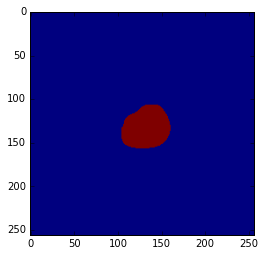

In [138]:
def draw_contour(ctr_path, show = False):
#   load into image format
    ctrs = np.loadtxt(ctr_path, delimiter=" ").astype(np.int)
    label = np.zeros((w,h), dtype="uint8")
    cv2.fillPoly(label, [ctrs], 1)
    mask = (label==1)
    label[mask]=255
    
    if show:
      plt.imshow(label)
      plt.show()
    
#   make destination path
    segments = ctr_path.split('/')
    ci_path = '/'.join(segments[:9])
    ci_path = os.path.join(ci_path,'label_image')
    try:
      os.mkdir(ci_path)
    except: 
      pass
    
    fname = segments[9]+'_'+'IM'+segments[-1].split('-')[2]+'.png'
    f_path = os.path.join(ci_path, fname)
    misc.imsave(f_path, label)
    
#---------------TEST--------------    
draw_contour(test,True)

In [123]:
print ONLINE_CONTOUR_PATH

/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours


In [139]:
for dirpath, dirnames, files in os.walk(ONLINE_CONTOUR_PATH):
  l = dirpath.split('/')[-1]
  if 'i'==l:
    print dirpath
    for f in files:
      if 'txt' in f:
        ctr_path = os.path.join(dirpath,f)
        draw_contour(ctr_path)          

/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-I-09/contours-manual/IRCCI-expert/i
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-I-10/contours-manual/IRCCI-expert/i
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-I-11/contours-manual/IRCCI-expert/i
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-I-12/contours-manual/IRCCI-expert/i
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-NI-12/contours-manual/IRCCI-expert/i
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-NI-13/contours-manual/IRCCI-expert/i
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-NI-14/contours-manual/IRCCI-expert/i
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HF-NI-15/contours-manual/IRCCI-expert/i
/Users/ZijiaLu/Documents/My_CS/Deep_Learning/D/DATA/OnlineDataContours/SC-HYP-09/contours-ma

# Second Second: Draw Label on the image

In [2]:
#make potential map dict
ONLINE_DICT={
  'SC-HF-I-09':['0241'],
  'SC-HF-I-10':['0024','0034'],
  'SC-HF-I-11':['0043','0047'],
  'SC-HF-I-12':['0062'],
  'SC-HF-NI-12': ['0286'],
  'SC-HF-NI-13':['0304'],
  'SC-HF-NI-14':['0330','0331','0332'],
  'SC-HF-NI-15':['0359'],
  'SC-HYP-09':['0003','0004','0007'],
  'SC-HYP-10':['0579','0583','0592'],
  'SC-HYP-11':['0601','0606'],
  'SC-HYP-12':['0629','0645'],
  'SC-N-09':['1031','1032','1034'],
  'SC-N-10':['0851','0852','0855'],
  'SC-N-11':['0877','0878','0882']
}

In [145]:
ONLINE_CONTOUR_PATH
CONTOUR_MDLE = 'contours-manual/IRCCI-expert'

>>>>NEW CONTOUR<<<<
Id: SC-HF-I-09/0241-0007 


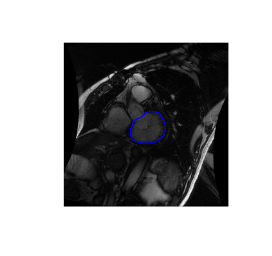

>>>>NEW CONTOUR<<<<
Id: SC-HF-I-09/0241-0018 


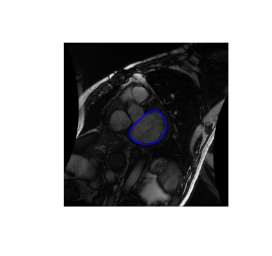

>>>>NEW CONTOUR<<<<
Id: SC-HF-I-09/0241-0027 


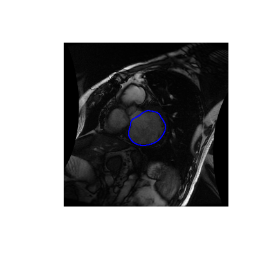

In [37]:
def patient_draw(case, Only_unsure = False, num = -1): # argument case should be contour's folder name. eg. SC-HF-I-09
  candi = ONLINE_DICT[case]
  if (not Only_unsure or len(candi)>1):
    #get txt list
    p_cfolder_path = os.path.join(ONLINE_CONTOUR_PATH,case,'contours-manual','IRCCI-expert','i')

    count = 0
    for c_txt in os.listdir(p_cfolder_path):
      #only draw the first $num of images
      if(count == num):
        break
      else:
        count = count + 1
    
      if(count == 5):
        break

      #get img_no
      img_no = int(c_txt.split('-')[2])
      #get ctr_mask
      ctr_path = os.path.join(p_cfolder_path,c_txt)
      cpts = np.loadtxt(ctr_path, delimiter=" ").astype(np.int) 

      #draw the image
      print '>>>>NEW CONTOUR<<<<'
      for series in candi:
        print 'Id: %s/%s-%04d '%(case, series, img_no)
        try:
          filename = "IM-%s-%04d.dcm" % (series, img_no)
          img_path = os.path.join(ONLINE_IMG_PATH, shrink_case(case), filename)
          f = dicom.read_file(img_path)
          img = f.pixel_array.astype(np.int)
          
#           plt.figure(figsize = (8,8))
          plt.imshow(img,cmap = 'Greys_r')
          plt.plot(cpts[:,0],cpts[:,1],'-')
          plt.axis('off')
          plt.show()
        except Exception, e: 
          print 'encouter error'
          print e          
      
#----TEST----------
patient_draw('SC-HF-I-09', num = 3)

---------------Case:  SC-HF-I-09------------
---------------Case:   SC-HYP-11------------
>>>>NEW CONTOUR<<<<
Id: SC-HYP-11/0601-0080 


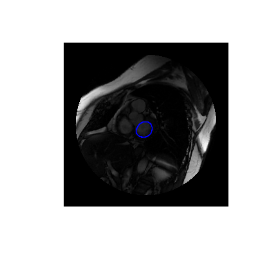

Id: SC-HYP-11/0606-0080 


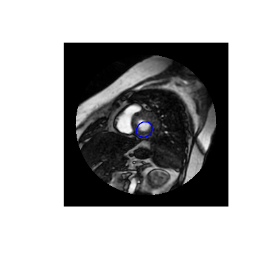

>>>>NEW CONTOUR<<<<
Id: SC-HYP-11/0601-0087 


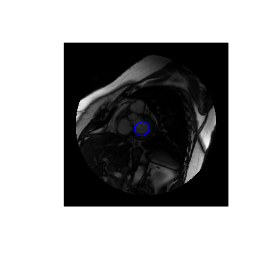

Id: SC-HYP-11/0606-0087 


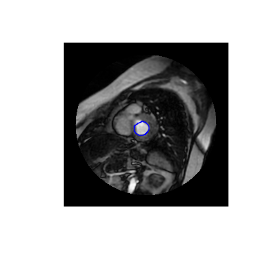

>>>>NEW CONTOUR<<<<
Id: SC-HYP-11/0601-0100 


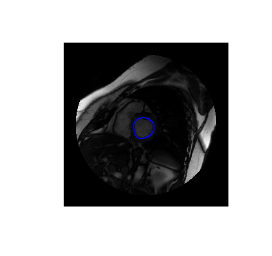

Id: SC-HYP-11/0606-0100 


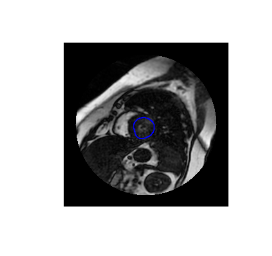

>>>>NEW CONTOUR<<<<
Id: SC-HYP-11/0601-0107 


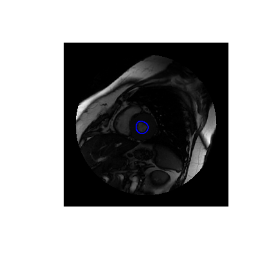

Id: SC-HYP-11/0606-0107 


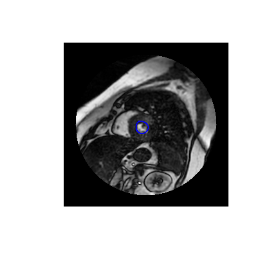

---------------Case:   SC-HYP-10------------
>>>>NEW CONTOUR<<<<
Id: SC-HYP-10/0579-0006 


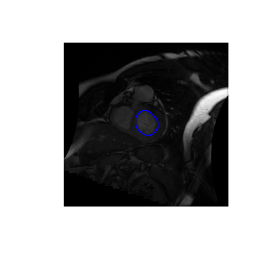

Id: SC-HYP-10/0583-0006 


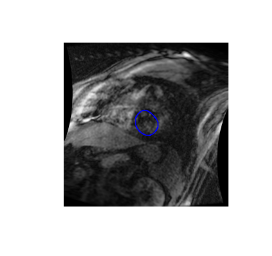

Id: SC-HYP-10/0592-0006 


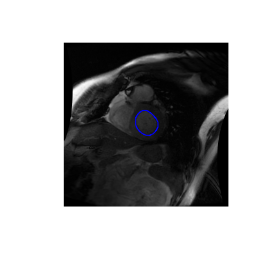

>>>>NEW CONTOUR<<<<
Id: SC-HYP-10/0579-0020 


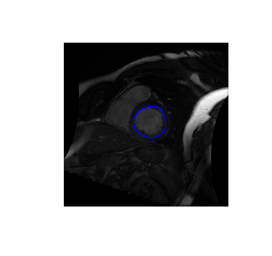

Id: SC-HYP-10/0583-0020 


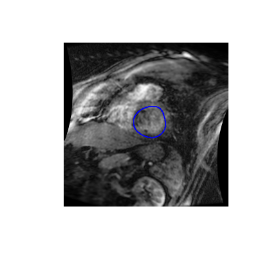

Id: SC-HYP-10/0592-0020 


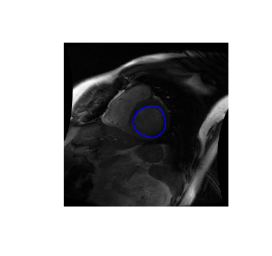

>>>>NEW CONTOUR<<<<
Id: SC-HYP-10/0579-0026 


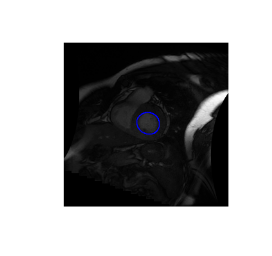

Id: SC-HYP-10/0583-0026 


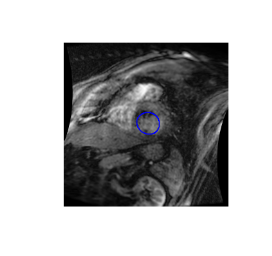

Id: SC-HYP-10/0592-0026 


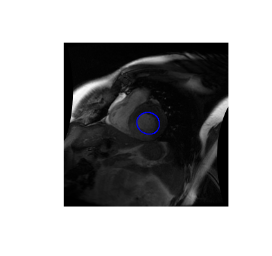

>>>>NEW CONTOUR<<<<
Id: SC-HYP-10/0579-0040 


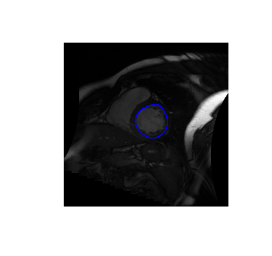

Id: SC-HYP-10/0583-0040 


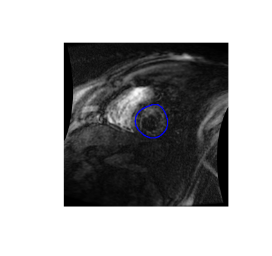

Id: SC-HYP-10/0592-0040 


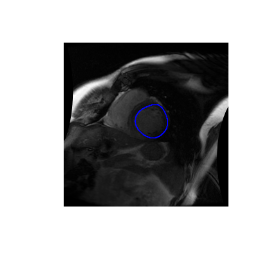

---------------Case:   SC-HYP-12------------
>>>>NEW CONTOUR<<<<
Id: SC-HYP-12/0629-0020 


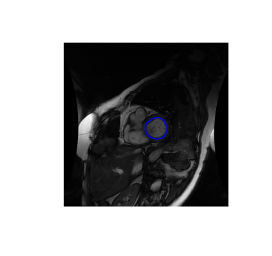

Id: SC-HYP-12/0645-0020 


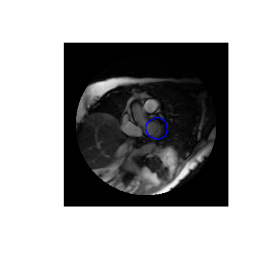

>>>>NEW CONTOUR<<<<
Id: SC-HYP-12/0629-0027 


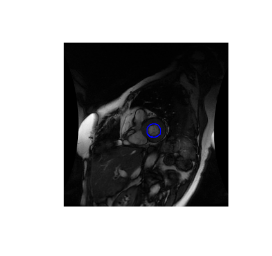

Id: SC-HYP-12/0645-0027 


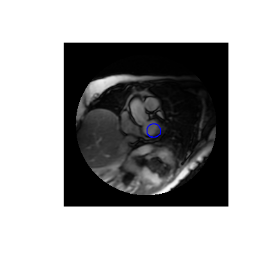

>>>>NEW CONTOUR<<<<
Id: SC-HYP-12/0629-0040 


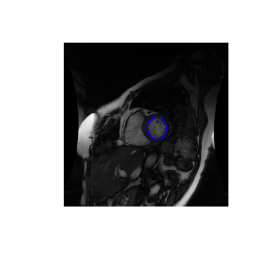

Id: SC-HYP-12/0645-0040 


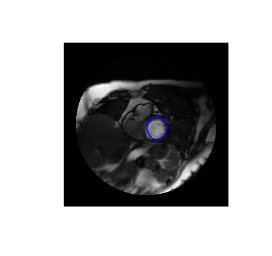

>>>>NEW CONTOUR<<<<
Id: SC-HYP-12/0629-0047 


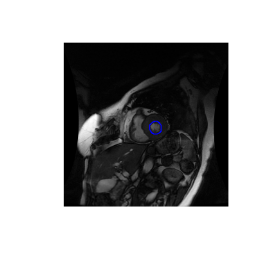

Id: SC-HYP-12/0645-0047 


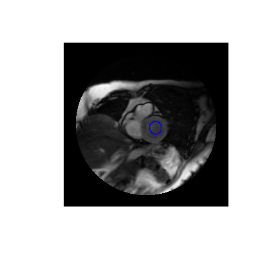

---------------Case:  SC-HF-I-11------------
>>>>NEW CONTOUR<<<<
Id: SC-HF-I-11/0043-0010 


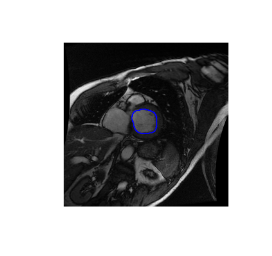

Id: SC-HF-I-11/0047-0010 


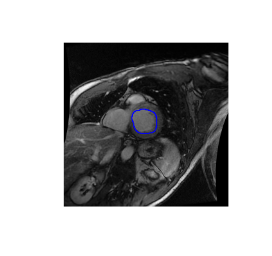

>>>>NEW CONTOUR<<<<
Id: SC-HF-I-11/0043-0020 


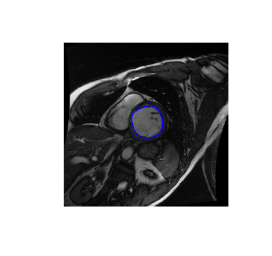

Id: SC-HF-I-11/0047-0020 


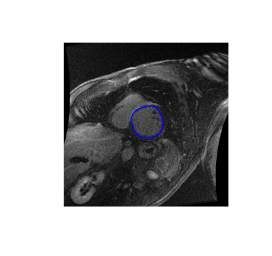

>>>>NEW CONTOUR<<<<
Id: SC-HF-I-11/0043-0030 


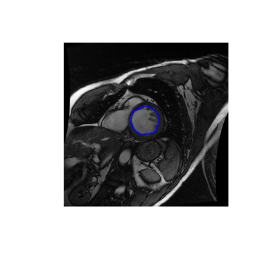

Id: SC-HF-I-11/0047-0030 


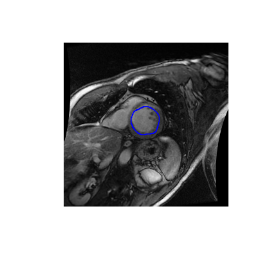

>>>>NEW CONTOUR<<<<
Id: SC-HF-I-11/0043-0040 


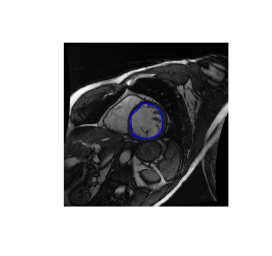

Id: SC-HF-I-11/0047-0040 


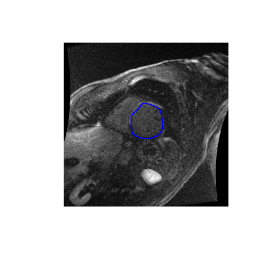

---------------Case:  SC-HF-I-10------------
>>>>NEW CONTOUR<<<<
Id: SC-HF-I-10/0024-0008 


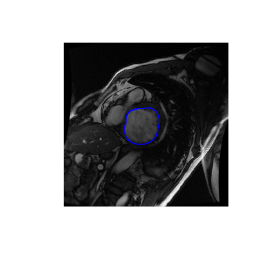

Id: SC-HF-I-10/0034-0008 


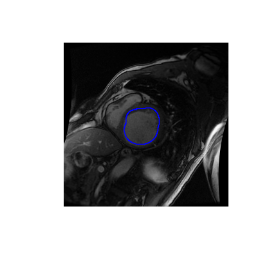

>>>>NEW CONTOUR<<<<
Id: SC-HF-I-10/0024-0020 


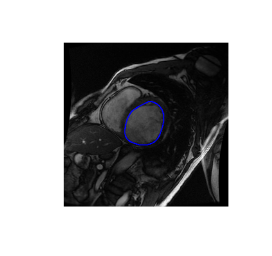

Id: SC-HF-I-10/0034-0020 


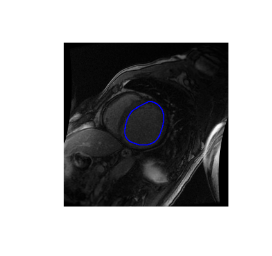

>>>>NEW CONTOUR<<<<
Id: SC-HF-I-10/0024-0028 


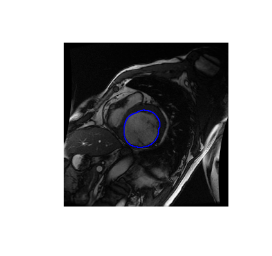

Id: SC-HF-I-10/0034-0028 


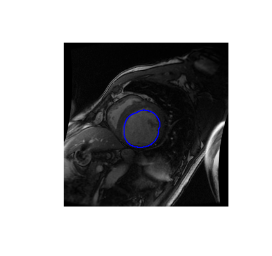

>>>>NEW CONTOUR<<<<
Id: SC-HF-I-10/0024-0040 


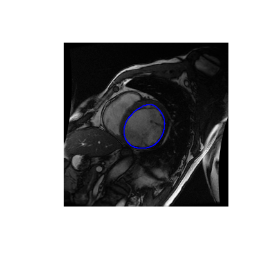

Id: SC-HF-I-10/0034-0040 


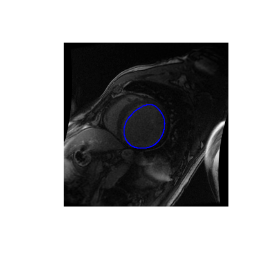

---------------Case:  SC-HF-I-12------------
---------------Case:   SC-HYP-09------------
>>>>NEW CONTOUR<<<<
Id: SC-HYP-09/0003-0060 


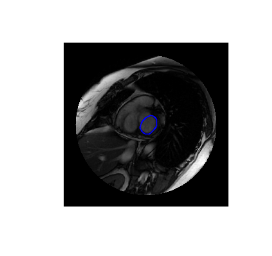

Id: SC-HYP-09/0004-0060 


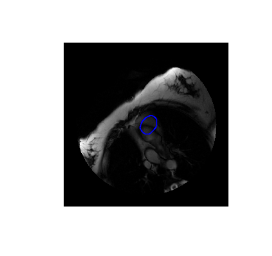

Id: SC-HYP-09/0007-0060 


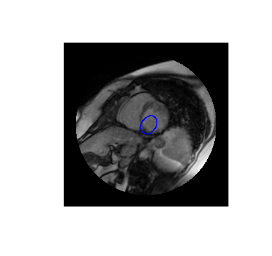

>>>>NEW CONTOUR<<<<
Id: SC-HYP-09/0003-0067 


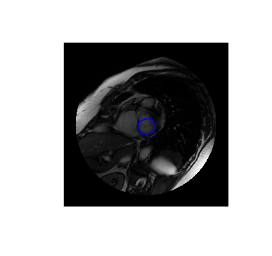

Id: SC-HYP-09/0004-0067 


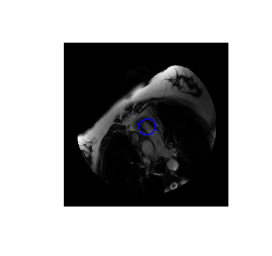

Id: SC-HYP-09/0007-0067 


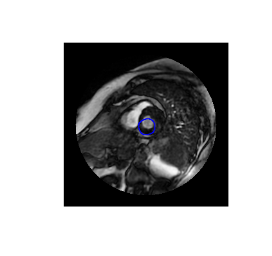

>>>>NEW CONTOUR<<<<
Id: SC-HYP-09/0003-0080 


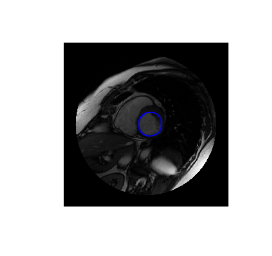

Id: SC-HYP-09/0004-0080 


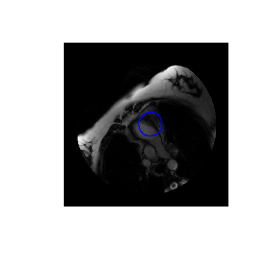

Id: SC-HYP-09/0007-0080 


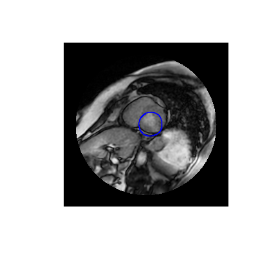

>>>>NEW CONTOUR<<<<
Id: SC-HYP-09/0003-0087 


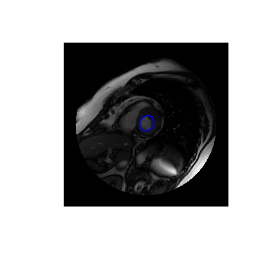

Id: SC-HYP-09/0004-0087 


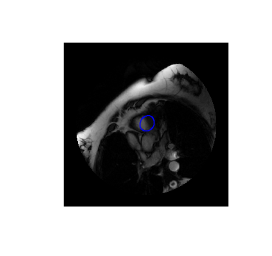

Id: SC-HYP-09/0007-0087 


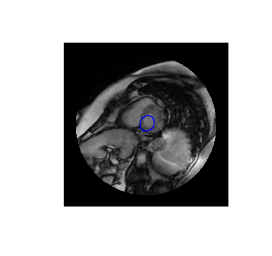

---------------Case: SC-HF-NI-12------------
---------------Case: SC-HF-NI-13------------
---------------Case: SC-HF-NI-14------------
>>>>NEW CONTOUR<<<<
Id: SC-HF-NI-14/0330-0076 


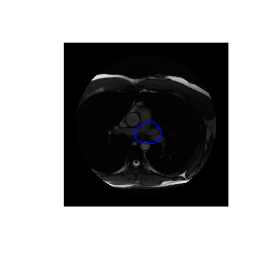

Id: SC-HF-NI-14/0331-0076 


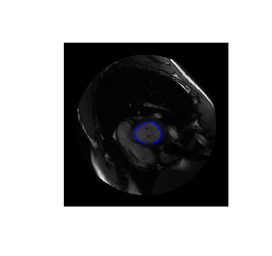

Id: SC-HF-NI-14/0332-0076 


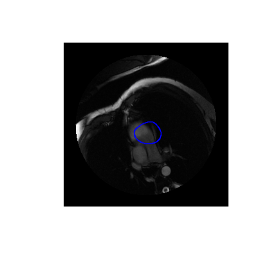

>>>>NEW CONTOUR<<<<
Id: SC-HF-NI-14/0330-0083 


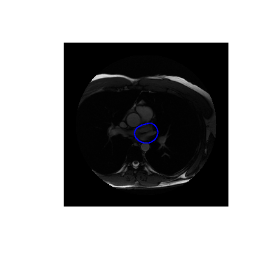

Id: SC-HF-NI-14/0331-0083 


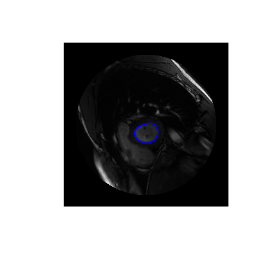

Id: SC-HF-NI-14/0332-0083 


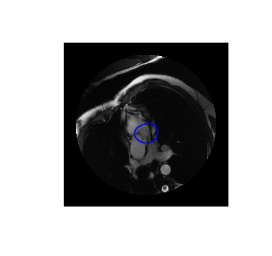

>>>>NEW CONTOUR<<<<
Id: SC-HF-NI-14/0330-0096 


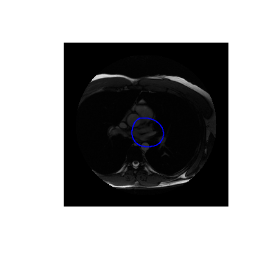

Id: SC-HF-NI-14/0331-0096 


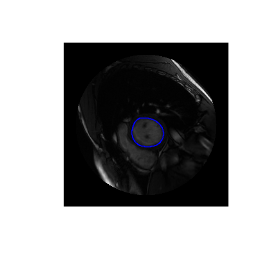

Id: SC-HF-NI-14/0332-0096 


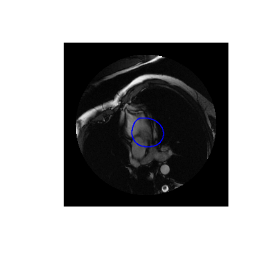

>>>>NEW CONTOUR<<<<
Id: SC-HF-NI-14/0330-0103 


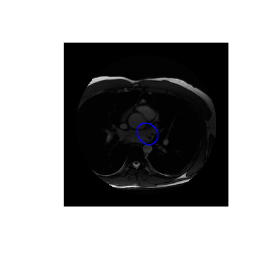

Id: SC-HF-NI-14/0331-0103 


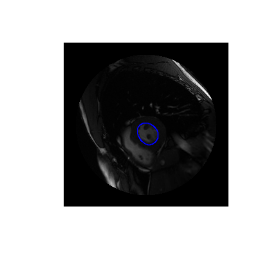

Id: SC-HF-NI-14/0332-0103 


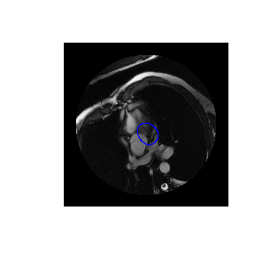

---------------Case: SC-HF-NI-15------------
---------------Case:     SC-N-09------------
>>>>NEW CONTOUR<<<<
Id: SC-N-09/1031-0020 


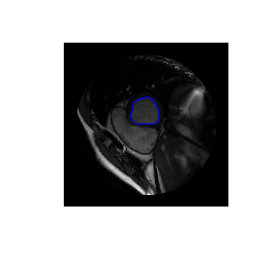

Id: SC-N-09/1032-0020 


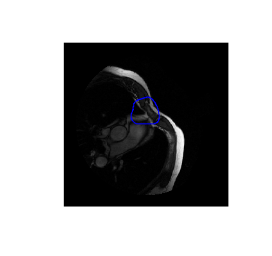

Id: SC-N-09/1034-0020 


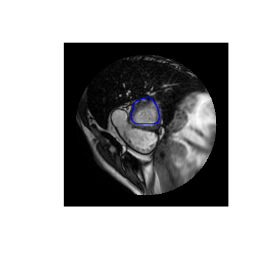

>>>>NEW CONTOUR<<<<
Id: SC-N-09/1031-0026 


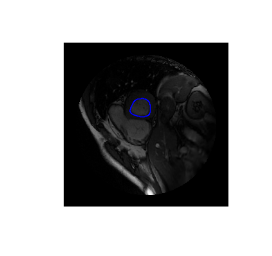

Id: SC-N-09/1032-0026 


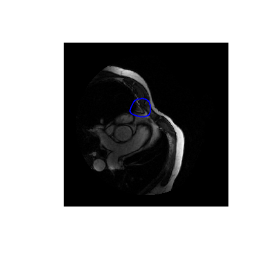

Id: SC-N-09/1034-0026 


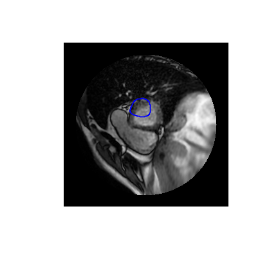

>>>>NEW CONTOUR<<<<
Id: SC-N-09/1031-0040 


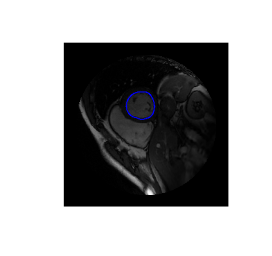

Id: SC-N-09/1032-0040 


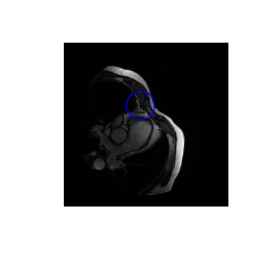

Id: SC-N-09/1034-0040 


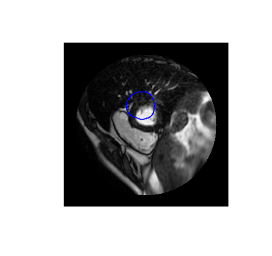

>>>>NEW CONTOUR<<<<
Id: SC-N-09/1031-0046 


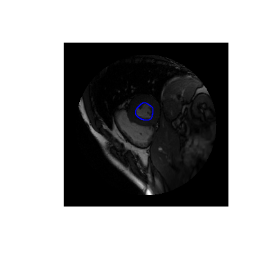

Id: SC-N-09/1032-0046 


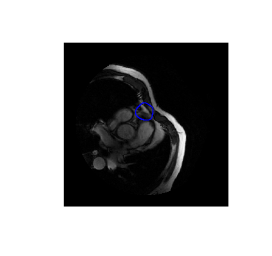

Id: SC-N-09/1034-0046 


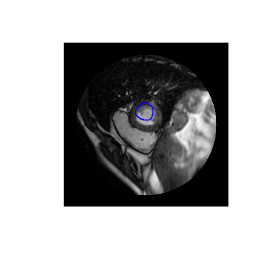

---------------Case:     SC-N-10------------
>>>>NEW CONTOUR<<<<
Id: SC-N-10/0851-0020 


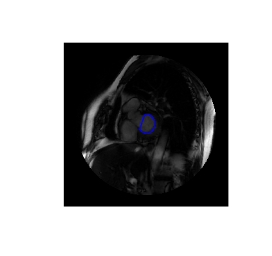

Id: SC-N-10/0852-0020 


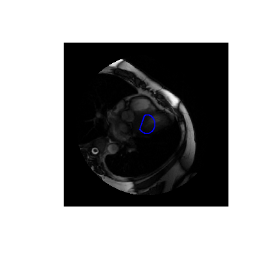

Id: SC-N-10/0855-0020 


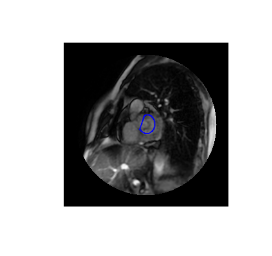

>>>>NEW CONTOUR<<<<
Id: SC-N-10/0851-0027 


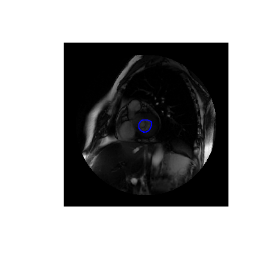

Id: SC-N-10/0852-0027 


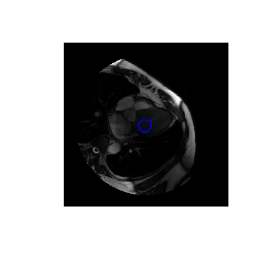

Id: SC-N-10/0855-0027 


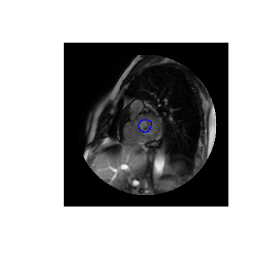

>>>>NEW CONTOUR<<<<
Id: SC-N-10/0851-0040 


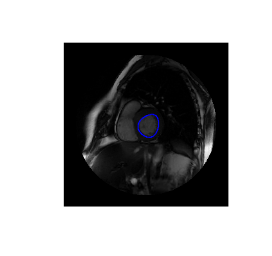

Id: SC-N-10/0852-0040 


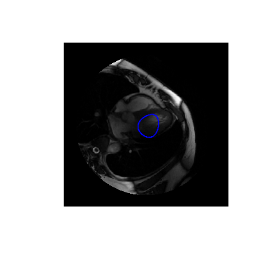

Id: SC-N-10/0855-0040 


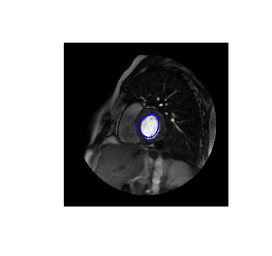

>>>>NEW CONTOUR<<<<
Id: SC-N-10/0851-0047 


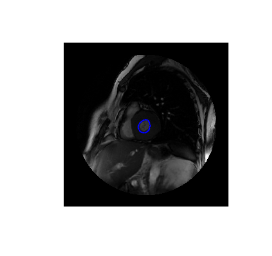

Id: SC-N-10/0852-0047 


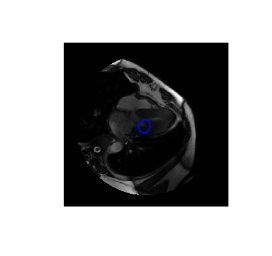

Id: SC-N-10/0855-0047 


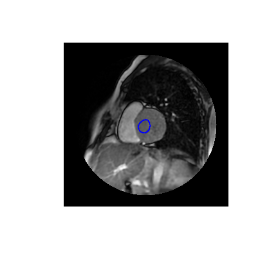

---------------Case:     SC-N-11------------
>>>>NEW CONTOUR<<<<
Id: SC-N-11/0877-0020 


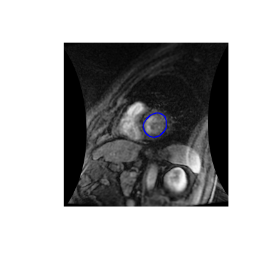

Id: SC-N-11/0878-0020 


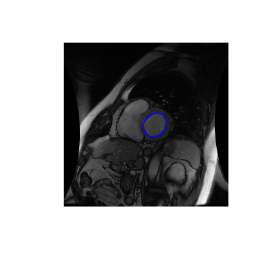

Id: SC-N-11/0882-0020 


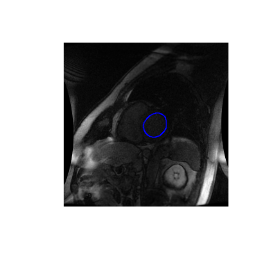

>>>>NEW CONTOUR<<<<
Id: SC-N-11/0877-0028 


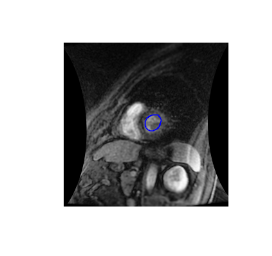

Id: SC-N-11/0878-0028 


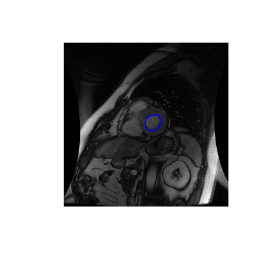

Id: SC-N-11/0882-0028 


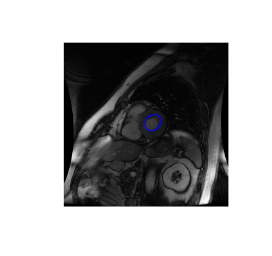

>>>>NEW CONTOUR<<<<
Id: SC-N-11/0877-0040 


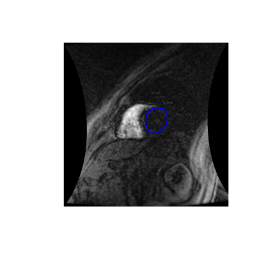

Id: SC-N-11/0878-0040 


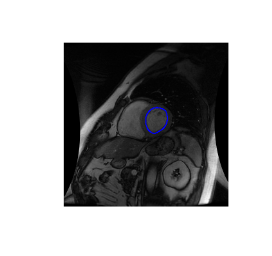

Id: SC-N-11/0882-0040 


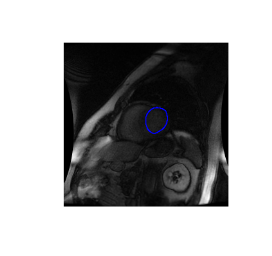

>>>>NEW CONTOUR<<<<
Id: SC-N-11/0877-0048 


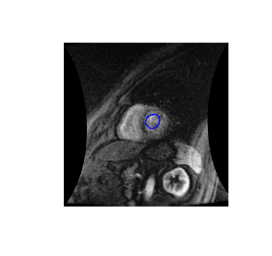

Id: SC-N-11/0878-0048 


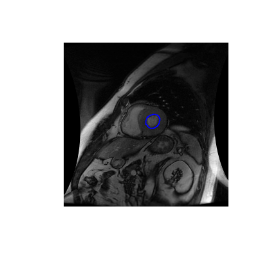

Id: SC-N-11/0882-0048 


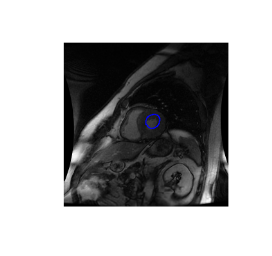

In [38]:
for case in ONLINE_DICT.keys():
  print '---------------Case: %11s------------'%(case)
  patient_draw(case,True)

In [39]:
CORRECT_ONLINE_DICT={
  'SC-HF-I-09':'0241',
  'SC-HF-I-10':'0024',
  'SC-HF-I-11':'0043',
  'SC-HF-I-12':'0062',
  'SC-HF-NI-12': '0286',
  'SC-HF-NI-13':'0304',
  'SC-HF-NI-14':'0331',
  'SC-HF-NI-15':'0359',
  'SC-HYP-09':'0003',
  'SC-HYP-10':'0592',
  'SC-HYP-11':'0601',
  'SC-HYP-12':'0629',
  'SC-N-09':'1031',
  'SC-N-10':'0851',
  'SC-N-11':'0878'
}